In [1]:
from scipy.signal import fftconvolve
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rescale, rotate
from skimage.filters import rank
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.filters import rank
from skimage.transform import ProjectiveTransform, warp
from skimage.filters import gabor_kernel
from scipy.signal import fftconvolve
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.transform import hough_line, hough_line_peaks
from skimage.morphology import skeletonize
from skimage.exposure import adjust_sigmoid, adjust_log
from skimage.util import img_as_ubyte
from skimage.transform import resize
import os

%matplotlib inline



def resize_im(im, max_side):
    """Resize an image so the its longer side is the specified length"""
    ratio = float(max_side_length) / max(im.shape[:2])
    new_h = int(round(ratio*im.shape[0]))
    new_w = int(round(ratio*im.shape[1]))
    return resize(im, (new_h, new_w))


def dist_angle_to_slope_interept(line):
    """Convert between line representations"""
    angle, dist = line
    slope = np.tan(angle - np.pi/2)
    y_intercept = dist / np.sin(angle)
    return slope, y_intercept


def line_intersection(line1, line2):
    """
    Compute the point of intersection between two lines 
    (in dist-angle representation)
    """
    if line1[0] == 0:
        print('line 1 vertical')
    if line2[0] == 0:
        a, c = dist_angle_to_slope_interept(line1)
        print('line 2 vertical')
        print(line1, a, c)
    a, c = dist_angle_to_slope_interept(line1)
    b, d = dist_angle_to_slope_interept(line2)
    if a == b:  # lines are parallel or coincident
        return None
    x = (d - c) / (a - b)
    y = (a*d - b*c) / (a - b)
    return x, y


def line_invrot90(line, im_shape):
    """
    Rotate a line in dist-angle representation in the same sense as np.rot90
    """
    theta1, d1 = line
    theta2 = np.pi/2 - theta1
    if abs(theta2) == 0 :
        return 0, im_shape[0] - d1
    x1, y1 = d1 * np.cos(theta1), d1 * np.sin(theta1)
    h1 = d1 / np.cos(theta2)
    h2 = im_shape[0] - h1
    d2 = h2 * np.cos(theta2)
    return -theta2, d2


def edge_response(im, sigma, thetas=np.linspace(-np.pi/10, np.pi/10, 5)):
    """Compute the edge response max-pooled over a range of orientations"""
    kernels = []
    for theta in thetas:
        kern = gabor_kernel(.1/sigma, theta=theta, sigma_x=sigma, sigma_y=2*sigma, n_stds=2).imag
        kern = np.rot90(kern, 3)
        kernels.append(np.fliplr(np.flipud(kern)))

    # kernel responses, max pooled over orientations
    resp_im = np.zeros_like(im)
    for kern in kernels:
        resp = fftconvolve(im, kern, mode='same')
        resp_im = np.maximum(resp, resp_im)
    return resp_im


def brightest_object_mask(gray):
    """
    Threshold a grayscale response image and return a mask of the brightest object
    """
    edges = gray > threshold_otsu(gray)

    # create a mask containing the object with the strongest response
    label_im = measure.label(edges)
    regions = measure.regionprops(label_im)
    if len(regions) == 0:
        raise ValueError('mask must have at least one object')
    max_resp = 0
    for region in regions:
        lbl = region.label
        mask = label_im == lbl
        region_resp = gray[mask].sum()
        if region_resp > max_resp:
            max_resp = region_resp
            max_region = region
    largest_object_mask = label_im == max_region.label
    return largest_object_mask


def best_horizontal_line(im, theta_range=np.pi/10, n_theta=5):
    """Find the dominant horizontal (dark-above-bright) line in an image"""
    
    # Compute horizontal edges, get biggest outline
    resp_im = edge_response(im, sigma=5, thetas=np.linspace(-theta_range, theta_range, n_theta))
    outline_mask = brightest_object_mask(resp_im)
    
    # FIXME: if outline map overlaps the top of im, this means that the receipt
    #        is not centered correctly (receipt edge outside frame)
    
    # Hough transform
    h, theta, d = hough_line(skeletonize(outline_mask), theta=np.linspace(-np.pi/2, np.pi/2, 180))
    _, angles, dists = hough_line_peaks(h, theta, d, threshold=0.1 * h.max(), num_peaks=10)
    
    # Compute gradient strength along each Hough line
    line_strength_dict = {}
    for angle, dist in zip(angles, dists):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - outline_mask.shape[1] * np.cos(angle)) / np.sin(angle)
        y0 = min([y0, outline_mask.shape[0]])
        y1 = min([y1, outline_mask.shape[0]])
        pt1 = (y0, 0)
        pt2 = (y1, outline_mask.shape[1])
        line_profile = measure.profile_line(resp_im, pt1, pt2)
        line_strength_dict[(angle, dist)] = line_profile.mean()

    horizontal_lines = [line for line in line_strength_dict if np.pi/2 - abs(line[0]) < theta_range]
    try:
        best_line = max(horizontal_lines, key=lambda x: line_strength_dict[x])
    except ValueError:
        return None
    return best_line


def get_receipt_edges(gray):
    """The (straight-line) edges of a centered 4-sided white object"""

    # TODO: disk/selem size should be fraction of input size
    median = rank.median(gray, disk(11))
    
    # Divide into halves
    top_im = median[:int(im.shape[0]/2), :]
    bottom_im = median[int(im.shape[0]/2):, :]
    left_im = median[:, :int(im.shape[1]/2)]
    right_im = median[:, int(im.shape[1]/2):]

    # Rotate so center is down, detect best horizontal line
    top_line = best_horizontal_line(top_im)
    left_line = best_horizontal_line(np.rot90(left_im,3))
    right_line = best_horizontal_line(np.rot90(right_im))
    bottom_line = best_horizontal_line(np.rot90(bottom_im,2))
    
    # Rotate back to original orientation
    right_line = line_invrot90(right_line, np.rot90(right_im).shape)
    bottom_line = line_invrot90(line_invrot90(bottom_line, np.rot90(bottom_im,2).shape), np.rot90(bottom_im).shape)
    left_line = line_invrot90(line_invrot90(line_invrot90(left_line, np.rot90(left_im).shape), np.rot90(left_im,2).shape), np.rot90(left_im,3).shape) 

    # Correct for offset/cropping
    right_line = right_line[0], right_line[1] + np.cos(right_line[0])*gray.shape[1]/2
    bottom_line = bottom_line[0],  + bottom_line[1] + np.sin(bottom_line[0]) * gray.shape[0]/2
    
    return top_line, right_line, bottom_line, left_line



In [22]:
max_side_length = 1024
in_fn = 'data/receipt7.jpg'
im = plt.imread(in_fn)
im = resize_im(im, max_side_length)
gray = rgb2gray(im)


# Get the edges of the receipt
top_line, right_line, bottom_line, left_line = get_receipt_edges(gray)

# print(top_line, right_line, bottom_line, left_line)

/home/brian/miniconda3/envs/test/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/brian/miniconda3/envs/test/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [23]:

# Intersect to get corners
TR = line_intersection(top_line, right_line)
TL = line_intersection(top_line, left_line)
BR = line_intersection(bottom_line, right_line)
BL = line_intersection(bottom_line, left_line)

# Warp so receipt corners are image corners
transform = ProjectiveTransform()
height = max([BL[1] - TL[1], BR[1] - TR[1]])
width = max([TR[0] - TL[0], BR[1] - BL[1]])
src_pts = np.array([TL, TR, BL, BR])
dest_pts = np.array([[0, 0], 
                     [width, 0],
                     [0, height],
                     [width, height]
                    ])
success = transform.estimate(src_pts, dest_pts)
warped_im = warp(gray, transform.inverse)[:int(height), :int(width)]

warped_gray = rgb2gray(warped_im)
enhanced_gray = img_as_ubyte(adjust_log(warped_gray))


fname, ext = os.path.splitext(in_fn)
out_fn = fname + '_preprocessed' + ext
plt.imsave(out_fn, enhanced_gray)


/home/brian/miniconda3/envs/test/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/home/brian/miniconda3/envs/test/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(-0.5, 460.5, 800.5, -0.5)

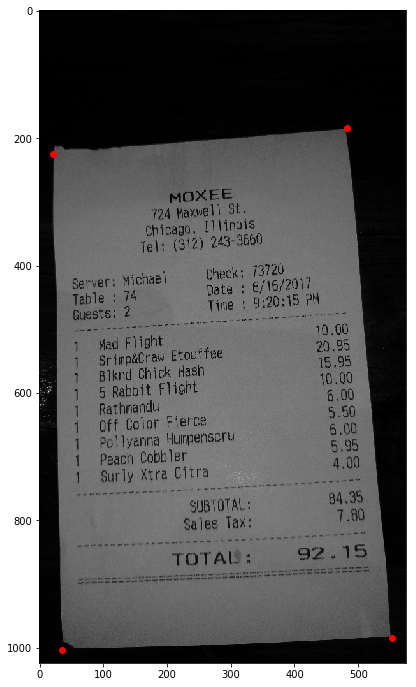

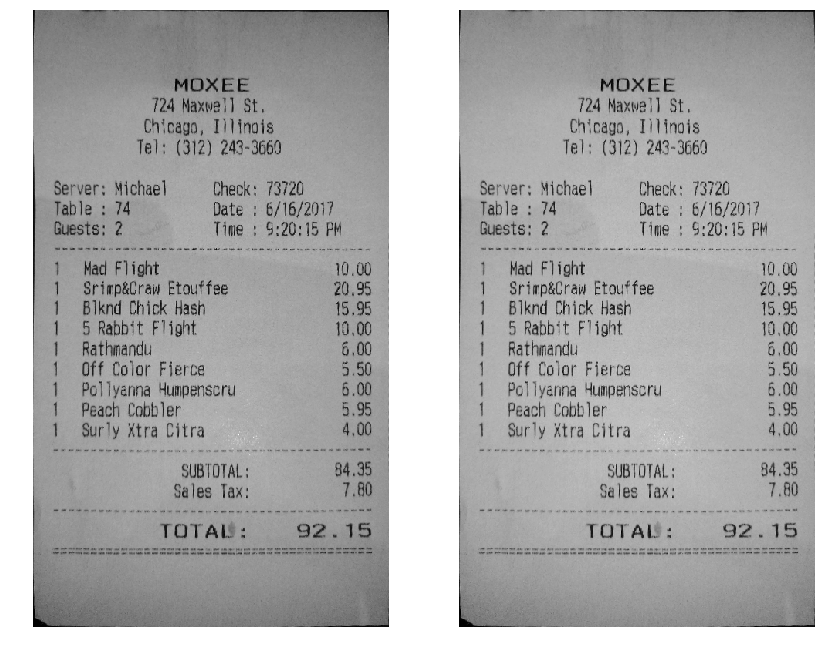

In [24]:
plt.figure(figsize=(12,12))
plt.imshow(gray, cmap='gray')
plt.plot(TR[0], TR[1], 'ro')
plt.plot(TL[0], TL[1], 'ro')
plt.plot(BR[0], BR[1], 'ro')
plt.plot(BL[0], BL[1], 'ro')

plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(img_as_ubyte(warped_gray), cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(enhanced_gray, cmap='gray')
plt.axis('off')
